In [ ]:
test_track_dir = "hw1/test_track/"

In [ ]:
embedding_dir = "hw1/embedding/"

In [ ]:
import matplotlib.pyplot as plt
from glob import glob
import os
import json
import pretty_midi
import numpy as np
import argparse
import pickle


with open('hw1/class_idx2MIDIClass.json') as f:
    class_idx2MIDIClass = json.load(f)
with open('hw1/idx2instrument_class.json') as f:
    idx2instrument_class = json.load(f)
with open('hw1/MIDIClassName2class_idx.json') as f:
    MIDIClassName2class_idx = json.load(f)

categories = [
    'Piano', 'Percussion', 'Organ', 'Guitar', 'Bass', 
    'Strings', 'Voice', 'Wind Instruments', 'Synth'
    ]

def parse_opt():
    parser = argparse.ArgumentParser()
    parser.add_argument('--test_track_dir', type=str,
                        help='source(test) midi track folder path', default='./test_track')
    parser.add_argument('--save_dir', type=str,
                        help='saved fig folder path', default='./')
    args = parser.parse_args()
    return args

def extract_pianoroll_from_midi(midi_file_path, time_step=5.0):
    midi_data = pretty_midi.PrettyMIDI(midi_file_path)
    # print(midi_data)
    
    # Determine total duration in seconds
    total_time = midi_data.get_end_time()
    
    # Create an empty pianoroll matrix without the "Empty" class
    num_classes = len(class_idx2MIDIClass)
    num_time_steps = int(np.ceil(total_time / time_step))
    pianoroll = np.zeros((num_classes, num_time_steps))
    
    # Process each instrument in the MIDI file
    for instrument in midi_data.instruments:
        program_num = instrument.program
        
        if instrument.is_drum:
            instrument_class = 128
        else:
            # Determine the class for this instrument
            instrument_class = idx2instrument_class.get(str(program_num), None)
        if instrument_class and instrument_class in MIDIClassName2class_idx:
            class_idx = MIDIClassName2class_idx[instrument_class]
            
            # Fill the pianoroll for each note
            for note in instrument.notes:
                start_time = note.start
                end_time = note.end
                start_idx = int(np.floor(start_time / time_step))
                end_idx = int(np.ceil(end_time / time_step))
                pianoroll[class_idx, start_idx:end_idx] = 1  # Mark the note as present
    
    return pianoroll

def pianoroll_comparison(true_pianoroll, pred_pianoroll, save_path):
    
    fig, axes = plt.subplots(2, 1, figsize=(15, 8))

    # Plotting the true pianoroll
    axes[0].imshow(true_pianoroll, aspect='auto', cmap='Oranges', interpolation='nearest')
    axes[0].set_title('True Labels')
    axes[0].set_yticks(range(len(categories)))
    axes[0].set_yticklabels(categories)
    axes[0].set_xlabel('Time Steps')

    # Plotting the predicted pianoroll
    axes[1].imshow(pred_pianoroll, aspect='auto', cmap='Oranges', interpolation='nearest')
    axes[1].set_title('Predicted Labels')
    axes[1].set_yticks(range(len(categories)))
    axes[1].set_yticklabels(categories)
    axes[1].set_xlabel('Time Steps')

    # label the file nwme on the top
    fig.suptitle(os.path.basename(save_path).split('.')[0])

    plt.tight_layout()
    # plt.show()
    plt.savefig(save_path)

/opt/homebrew/anaconda3/lib/python3.12/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


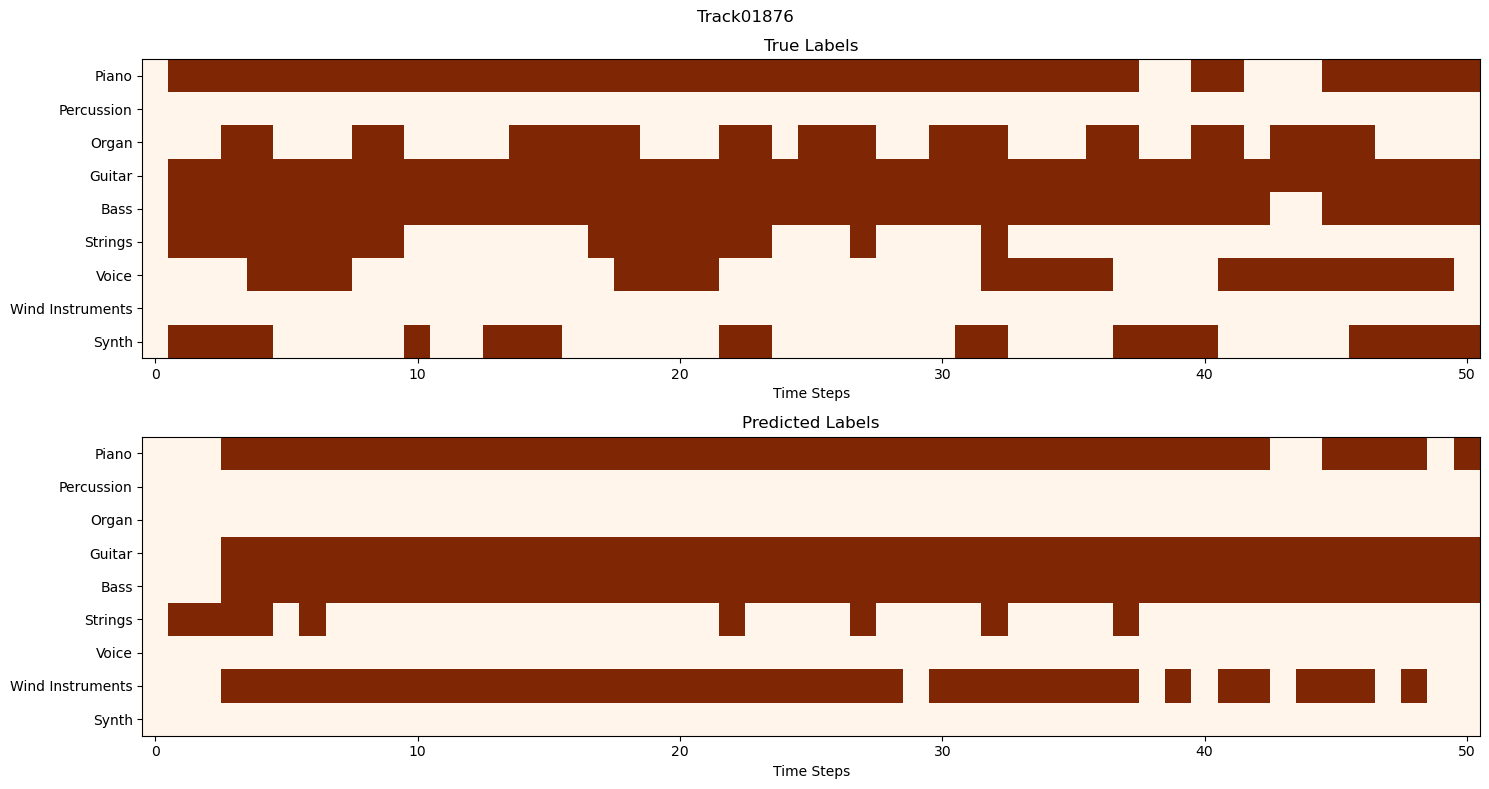

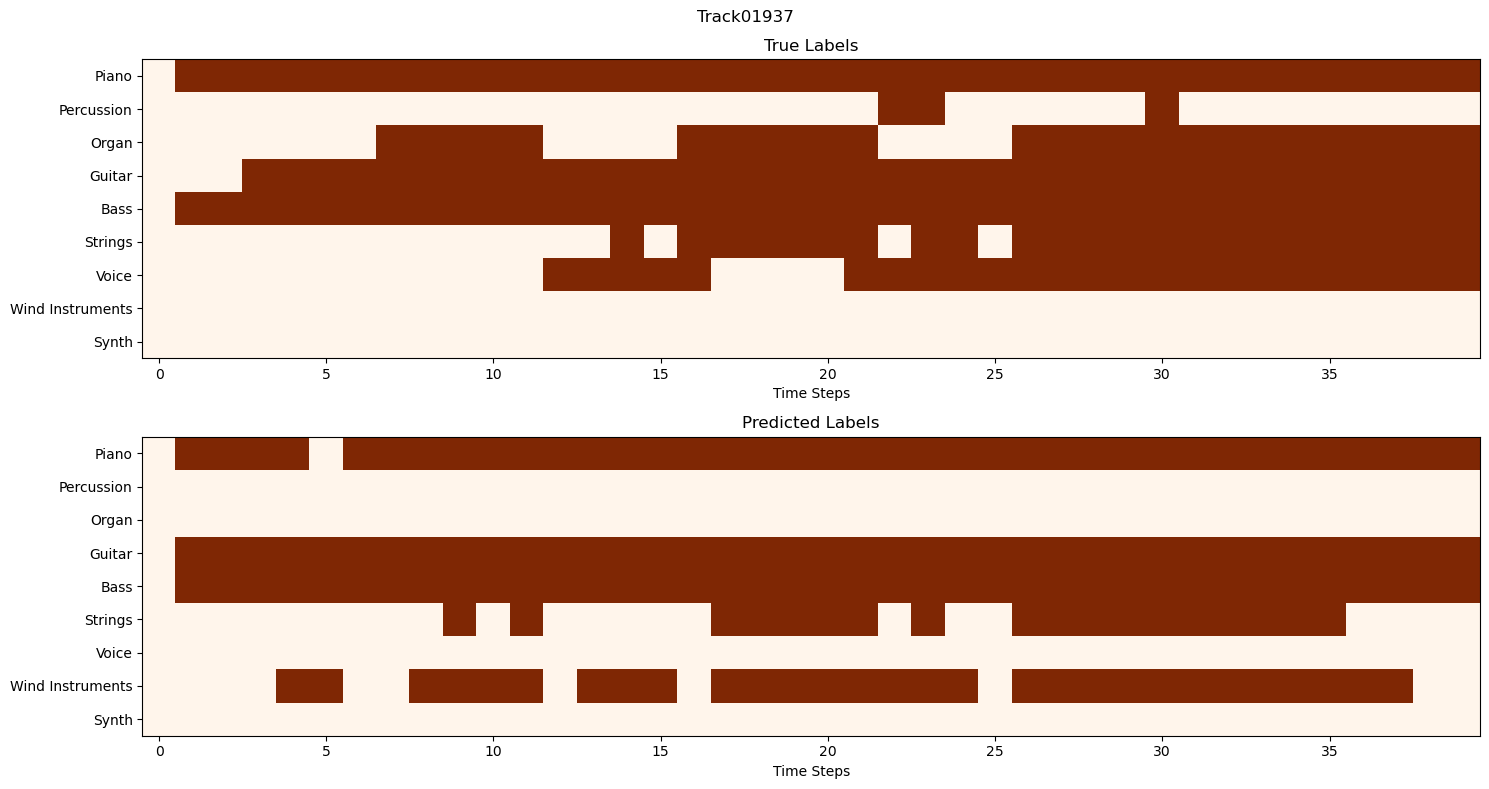

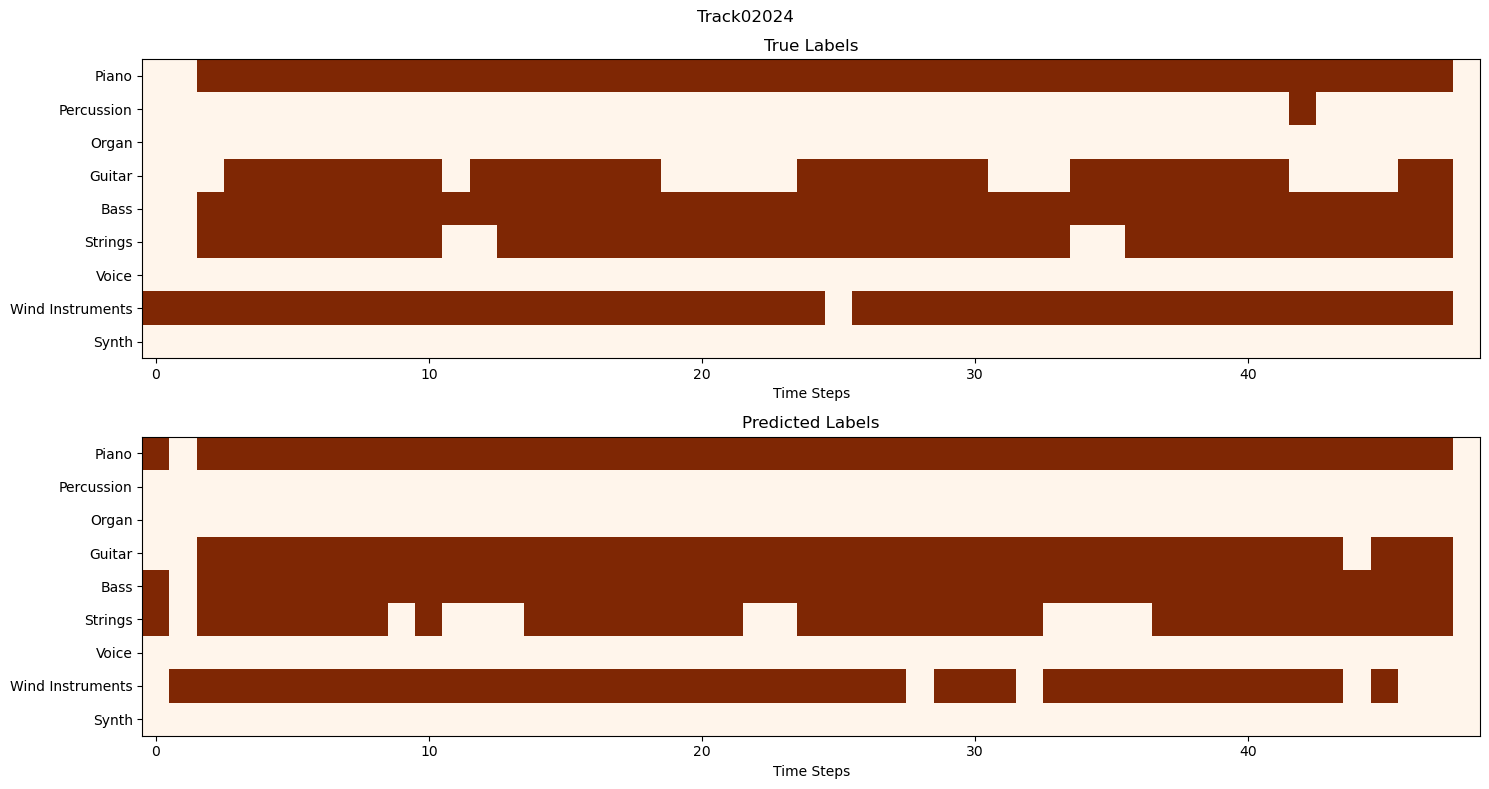

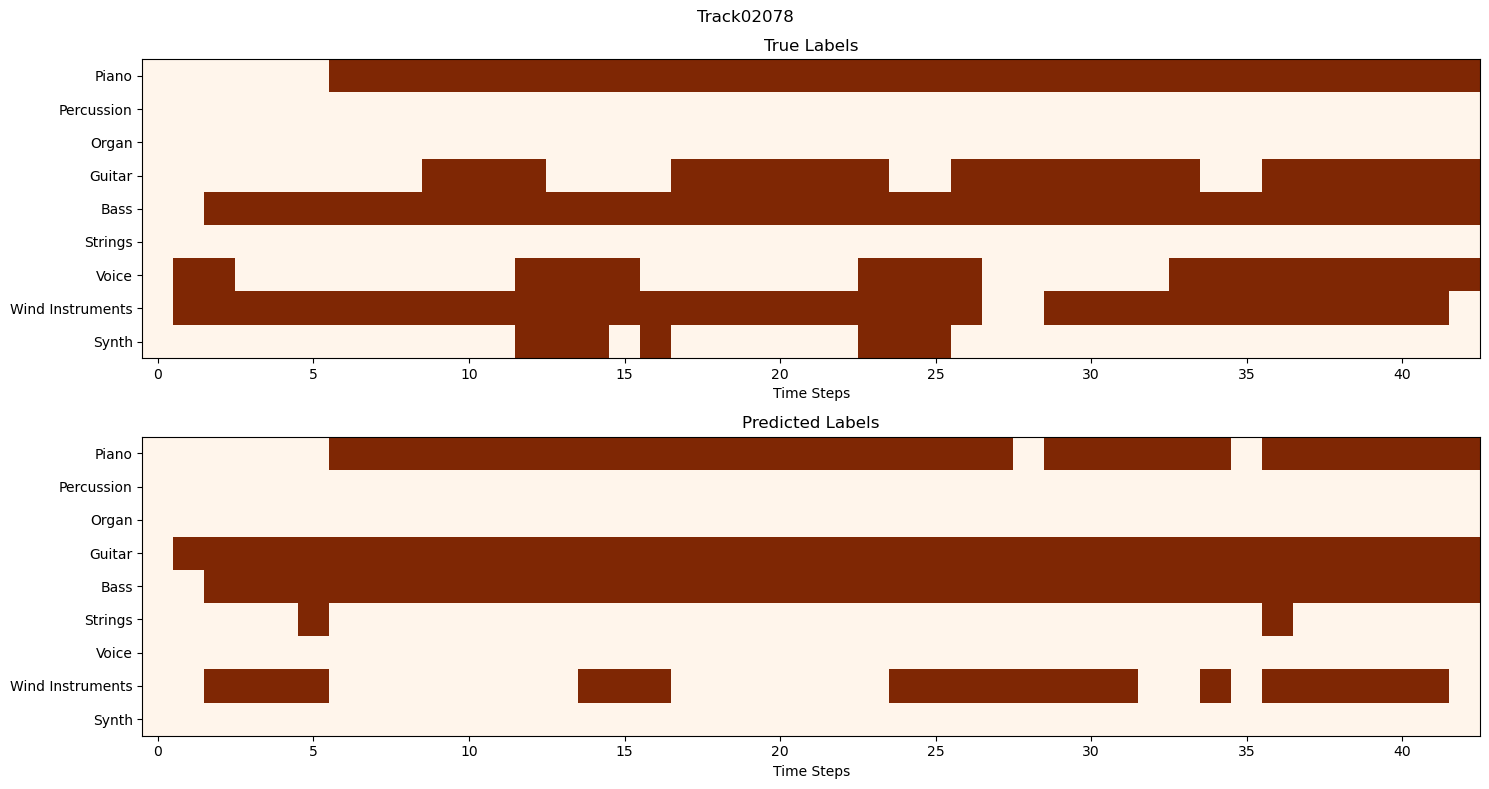

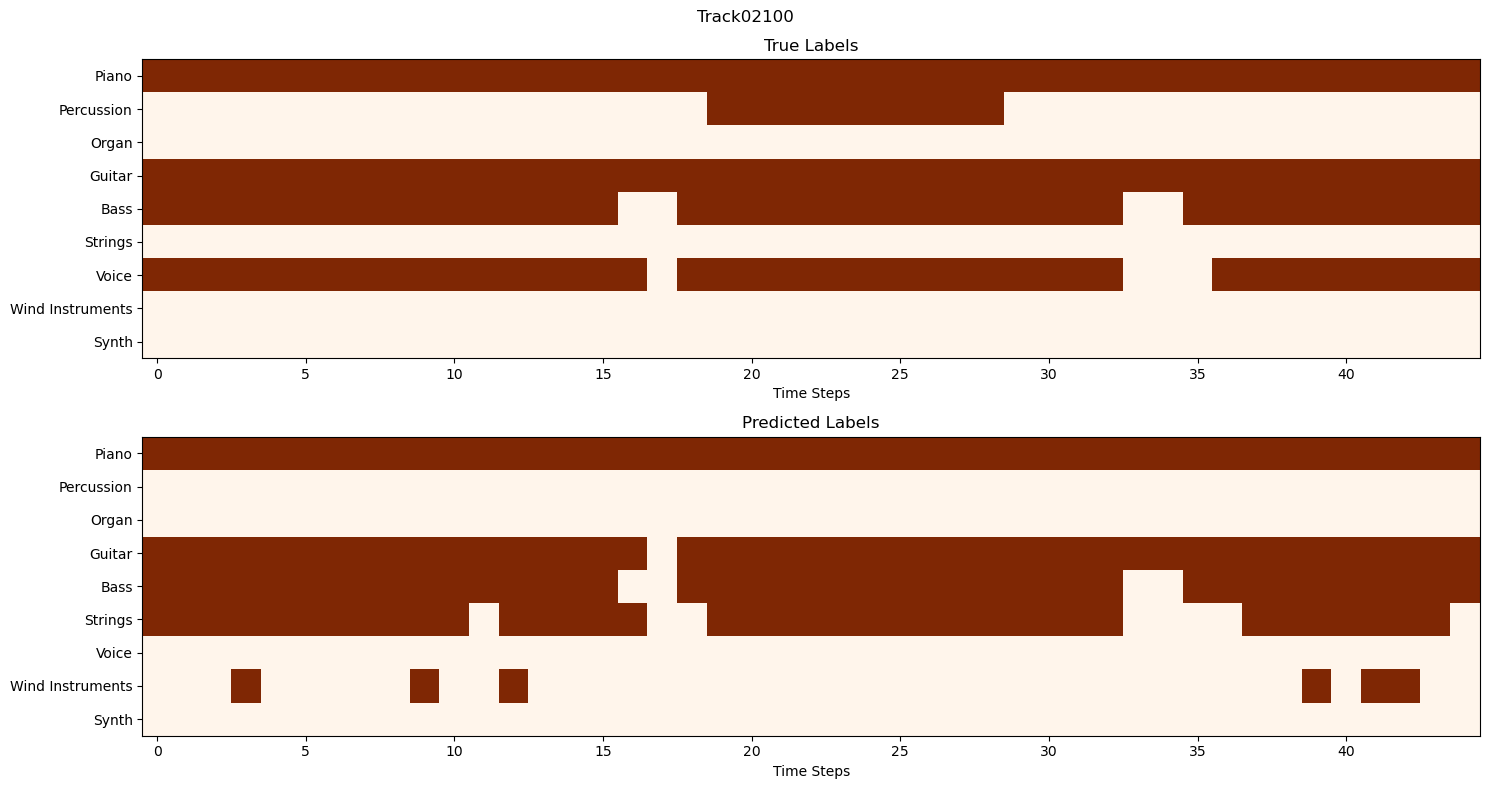

In [26]:
midi_path_list = glob(os.path.join(test_track_dir, '*.mid'))
# audio_path_list = glob(os.path.join(test_track_dir, '*.flac'))

# sort the midi_path_list
midi_path_list.sort()

for src_path in midi_path_list:
    name = src_path.split('/')[-1].split('.')[0]
    true_pianoroll = extract_pianoroll_from_midi(src_path)
    # pred_pianoroll is your model predict result please load your results here
    # pred_pianoroll.shape should be [9, L] and the L should be equal to true_pianoroll
    
    # get file name, without the folder and .mid
    name = src_path.split('/')[-1].split('.')[0]
    # read from pickle file
    with open(embedding_dir + name + '.pkl', 'rb') as f:
        pred_pianoroll = pickle.load(f)

    # cast to numpy array
    pred_pianoroll = np.array(pred_pianoroll)
    # transpose the pred_pianoroll
    pred_pianoroll = pred_pianoroll.T

    # pred_pianoroll = np.zeros(true_pianoroll.shape)
    # print(pred_pianoroll.shape)
    pianoroll_comparison(true_pianoroll, pred_pianoroll, name+'.png')